<a href="https://colab.research.google.com/github/PravyPrerana-1610/Codes/blob/main/EE_on_line_PerBoun_Schmidt_Decomp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 100/100 [00:00<00:00, 2360.86it/s]


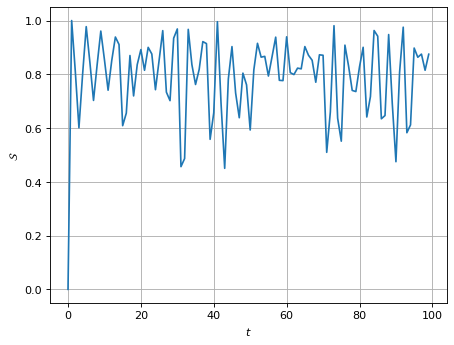

In [6]:
import numpy as np
import scipy.sparse as sy
from scipy.sparse import identity, hstack, csr_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

L = 5
sites = 2 * L + 1
p_tumble = 0
t = 100


def coin():
    return np.array([[np.sqrt(0.5), np.sqrt(0.5)],
                     [np.sqrt(0.5), -np.sqrt(0.5)]])

def not_gate():
    return np.array([[0, 1], [1, 0]])

def global_coin(sites):
    return sy.kron(identity(sites, format="csr"), csr_matrix(coin()))

def tumble_coin(sites):
    return sy.kron(identity(sites, format="csr"), csr_matrix(not_gate()))


up = np.array([[1], [0]])
down = np.array([[0], [1]])

# Shift operator with periodic boundary conditions
def shift(sites):
    A = identity(sites, format='csr')
    Sp = hstack((A[:, 1:], A[:, :1]), format='csr')   # shift right
    Sm = hstack((A[:, -1:], A[:, :-1]), format='csr') # shift left
    S = sy.kron(Sp, csr_matrix(up @ up.T)) + sy.kron(Sm, csr_matrix(down @ down.T))
    return S

# Initial state (localized at center)
init_coin = up
init_walker = np.zeros((sites, 1), dtype='complex')
init_walker[L, 0] = 1
init_state = csr_matrix(np.kron(init_walker, init_coin))

# Generate tumble process
def generate_process(time, pt):
    tumb = np.zeros(time, dtype=int)
    v = np.ones(time, dtype=int)
    for tt in range(1, time):
        dec = np.random.rand()
        if dec < pt:
            tumb[tt] = 1
            v[tt] = np.random.randint(1, 10)
        else:
            v[tt] = v[tt - 1]
    return tumb, v

processes = generate_process(t, p_tumble)

def schmidt_entropy_sparse(state, sites):
    # Convert sparse state to 1D complex vector
    psi = np.array(state.toarray()).flatten()

    # Reshape into (sites, 2) matrix for coin-position bipartition
    psi_matrix = psi.reshape((sites, 2))
    _, s, _ = np.linalg.svd(psi_matrix, full_matrices=False)

    s = s / np.linalg.norm(s)

    entropy = -np.sum((s ** 2) * np.log2(s ** 2 + 1e-15))
    return entropy


S = shift(sites)
G = global_coin(sites)
T = tumble_coin(sites)

def propagate(state, tumble, v):
    if tumble == 1:
        state = T @ state
    else:
        state = (S ** v) @ G @ state
    return state


entropy = np.zeros(t)
state = init_state.copy()

for i in tqdm(range(t)):
    entropy[i] = schmidt_entropy_sparse(state, sites)
    state = propagate(state, processes[0][i], processes[1][i])


plt.figure(dpi=80)
plt.plot(entropy)
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathcal{S}$")
plt.grid(True)
plt.show()


In [7]:
entropy[1]

np.float64(0.999999999999997)